# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>1. Import Library</b></div>

<div style="border-radius:10px; border: #FFA500 solid; padding: 15px; font-size:100%;">

📌 **Experimental Parameters**
    
- `Image Size`: 256X256
    
- `Label Unique`: Label Unique>=2 & No Finding 삭제 
    
- `CLAHE(Contrast Limited Adaptive Histogram Equalization)`: clipLimit: 2.0, tileGridSize: (8,8) 

- `Label Smoothing`: 0.15
    
- `Loss`: CategorialCrossEntropy
    
- `Fold`: SKF(n_splits=5) But, Only Traininig Fold1
    
- `Weak Augment`: HFlip, Rotate(limit=2.5)
    
- `Strong Augment`: X
  
- `BackBone Model`: TF EfficientNetB0 Noisy Student
    
- `Freezing Layer`: 10% Layers
    
- `Batch Size`: 16
    
- `Learning Rate`: 1e-3
    
- `Epoch`: 10
    
- `Optimizer`: Adam


In [1]:
import os
import gc 
import random
import ctypes
from tqdm import tqdm
from collections import defaultdict

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
import cv2
from PIL import Image
import albumentations as albu

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold, StratifiedGroupKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc

import warnings 
warnings.filterwarnings('ignore')


## tensorflow version
import tensorflow as tf
from tensorflow.keras import layers, Model, losses, optimizers
import tensorflow.keras.backend as K

print('tensorflow version: ', tf.__version__)
os.environ['CUDA_IS_VISIBLE'] = '0,1'
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '3'

gpus = tf.config.list_physical_devices('GPU')
if len(gpus) <=1:
    strategy = tf.distribute.OneDeviceStrategy(device='/gpu:0')
    print(f'Using {len(gpus)} GPUs')
else: 
    strategy = tf.distribute.MirroredStrategy()
    print(f'Using {len(gpus)} GPUs')
    
LOAD_MODELS_FROM = None
LOAD_SEGMENTATION_FROM = '/kaggle/input/cxr-unet/' # FPN ResNet18 512x512

tensorflow version:  2.16.1
Using 2 GPUs


In [2]:
def clean_memory():
    # malloc_trim: 현재 사용되지 않는 메모리를 시스템에서 다시 반환함0
    ctypes.CDLL('libc.so.6').malloc_trim(0)
    gc.collect()
clean_memory()

In [3]:
def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
seed_everything(42)

In [4]:
MIX = True
if MIX: 
    tf.config.optimizer.set_experimental_options({'auto_mixed_precision':True})
    print('Mixed Precision enabled')
else: 
    print('Using full precision')

Mixed Precision enabled


# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>2. Road and Read Data</b></div>

In [5]:
df = pd.read_csv('/kaggle/input/data/Data_Entry_2017.csv')
df = df.drop(columns='Unnamed: 11')
df = df[~df['Finding Labels'].str.contains('\|')]
df = df.reset_index(drop=True)
print(f'Shape of DataFrame: {df.shape}')
df.head(10)

Shape of DataFrame: (91324, 11)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143
1,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171
2,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143
3,00000003_001.png,Hernia,1,3,74,F,PA,2500,2048,0.168,0.168
4,00000003_002.png,Hernia,2,3,75,F,PA,2048,2500,0.168,0.168
5,00000003_004.png,Hernia,4,3,77,F,PA,2500,2048,0.168,0.168
6,00000003_005.png,Hernia,5,3,78,F,PA,2686,2991,0.143,0.143
7,00000003_006.png,Hernia,6,3,79,F,PA,2992,2991,0.143,0.143
8,00000003_007.png,Hernia,7,3,80,F,PA,2582,2905,0.143,0.143
9,00000005_000.png,No Finding,0,5,69,F,PA,2048,2500,0.168,0.168


In [6]:
%%time
tmp = {os.path.basename(x): x for x in glob(os.path.join('/kaggle', 'input', '*','*','images', '*.png'))}    
    
df['path'] = df['Image Index'].map(tmp)

CPU times: user 568 ms, sys: 77.1 ms, total: 645 ms
Wall time: 2.98 s


#### Loading Pneumonia
___

- width: 1200
- height: 825

In [7]:
df_pneumonia = pd.DataFrame()
df_pneumonia['Image Index'] = os.listdir('/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/')
df_pneumonia['Finding Labels'] = 'Pneumonia'
half = len(df_pneumonia) // 2
df_pneumonia['View Position'] = ['PA'] * half + ['AP'] * (len(df_pneumonia) - half)
df_pneumonia['Patient ID'] = [f'p_{i}' for i in range(len(df_pneumonia))]

tmp = {os.path.basename(x): x for x in glob(os.path.join('/kaggle', 'input', '*','*','train','*','*.jpeg'))}        
df_pneumonia['path'] = df_pneumonia['Image Index'].map(tmp)

df = pd.concat([df, df_pneumonia])
df = df.reset_index(drop=True)

#### Loading tuberculosis
___
- width: 3071
- height: 3145

In [8]:
china_index = os.listdir('/kaggle/input/pulmonary-chest-xray-abnormalities/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/')
new_index = []
for index in tqdm(china_index):
    if 'Thumbs' not in index:
        file_path = f'/kaggle/input/pulmonary-chest-xray-abnormalities/ChinaSet_AllFiles/ChinaSet_AllFiles/ClinicalReadings/{index.split(".")[0]}.txt'
        with open(file_path, 'r') as file:
            content = file.read()
        if 'normal' in content:
            new_index.append(index)

df_china = pd.DataFrame()
df_china['Image Index'] = new_index
df_china['Finding Labels'] = 'Tuberculosis'
df_china['View Position'] = 'PA'
df_china['Patient ID'] = [f't_{i}' for i in range(len(df_china))]

tmp = {os.path.basename(x): x for x in glob(os.path.join('../input/*/*/*/CXR_png/*.png'))}        
df_china['path'] = df_china['Image Index'].map(tmp)

100%|██████████| 663/663 [00:02<00:00, 270.37it/s]


In [9]:
mon_index = os.listdir('/kaggle/input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/CXR_png/')
new_index = []
for index in tqdm(mon_index):
    if 'Thumbs' not in index:
        file_path = f'/kaggle/input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/ClinicalReadings/{index.split(".")[0]}.txt'
        with open(file_path, 'r') as file:
            content = file.read()
        if 'normal' in content:
            new_index.append(index)

df_mon = pd.DataFrame()
df_mon['Image Index'] = new_index
df_mon['Finding Labels'] = 'Tuberculosis'
df_mon['View Position'] = 'PA'
df_mon['Patient ID'] = [f't_{i}' for i in range(len(df_mon))]

tmp = {os.path.basename(x): x for x in glob(os.path.join('../input/*/Montgomery/MontgomerySet/*/*.png'))}        
df_mon['path'] = df_mon['Image Index'].map(tmp)

100%|██████████| 139/139 [00:00<00:00, 338.39it/s]


In [10]:
df_tuberculosis = pd.concat([df_china, df_mon],axis=0)
df_tuberculosis = df_tuberculosis.reset_index(drop=True)

df = pd.concat([df, df_tuberculosis])
df = df.reset_index(drop=True)

#### Load Covid-19
___

- height: 825
- width: 1200

In [11]:
train_covid = pd.DataFrame()
train_covid['Image Index'] = os.listdir('/kaggle/input/chest-xray-pneumoniacovid19tuberculosis/train/COVID19/')
test_covid = pd.DataFrame()
test_covid['Image Index'] = os.listdir('/kaggle/input/chest-xray-pneumoniacovid19tuberculosis/test/COVID19/')
df_covid = pd.concat([train_covid, test_covid])
df_covid['Finding Labels'] = 'Covid'
half = len(df_covid) // 2
df_covid['View Position'] = ['PA'] * half + ['AP'] * (len(df_covid) - half)
df_covid['Patient ID'] = [f'c_{i}' for i in range(len(df_covid))]

tmp = {os.path.basename(x): x for x in glob(os.path.join('/kaggle', 'input', '*','*','*','*.jpg'))}        
df_covid['path'] = df_covid['Image Index'].map(tmp)

df = pd.concat([df, df_covid])
df = df.reset_index(drop=True)
df = df[['Image Index','Finding Labels', 'path','View Position','Patient ID']]

In [12]:
tmp = df.groupby('Patient ID')['Finding Labels'].nunique()
tmp = tmp.reset_index().rename(columns={'Finding Labels':'label_nunique'})

df = df.merge(tmp, on='Patient ID', how='left')

tmp1 = df.loc[df['label_nunique'] > 1][df['Finding Labels'] != 'No Finding']
tmp2 = df.loc[df['label_nunique'] == 1]

df = pd.concat([tmp1, tmp2], axis=0).reset_index(drop=True)

In [13]:
df_1 = pd.concat([df[df['Finding Labels'] == 'Edema'].sample(500, random_state=42)])
df_2 = pd.concat([df[df['Finding Labels'] == 'No Finding'].sample(500, random_state=42)])
df_3 = pd.concat([df[df['Finding Labels'] == 'Pneumonia'].sample(500, random_state=42)])
df_4 = pd.concat([df[df['Finding Labels'] == 'Tuberculosis']])
df_5 = pd.concat([df[df['Finding Labels'] == 'Pneumothorax'].sample(500, random_state=42)])
df_6 = pd.concat([df[df['Finding Labels'] == 'Emphysema'].sample(500, random_state=42)])
df_7 = pd.concat([df[df['Finding Labels'] == 'Covid'].sample(500, random_state=42)])
df_8 = pd.concat([df[df['Finding Labels'] == 'Effusion'].sample(500, random_state=42)])
df_9 = pd.concat([df[df['Finding Labels'] == 'Atelectasis'].sample(500, random_state=42)])


df = pd.concat([df_1,df_2,df_3,df_4,df_5,df_6,df_7,df_8,df_9])
df = df.reset_index(drop=True)

**Rapid Dataset**

=> There are 4,500 Datasets(each label has 500 datasets)

In [14]:
USE_RAPID = True

In [15]:
if USE_RAPID: 
    df = pd.read_csv('/kaggle/input/rapid-cxr-dataset/metadata.csv')
    tmp = {os.path.basename(x): x for x in glob(os.path.join('/kaggle', 'input', '*','*','*', '*'))}    
    
    df['path'] = df['Image Index'].map(tmp)

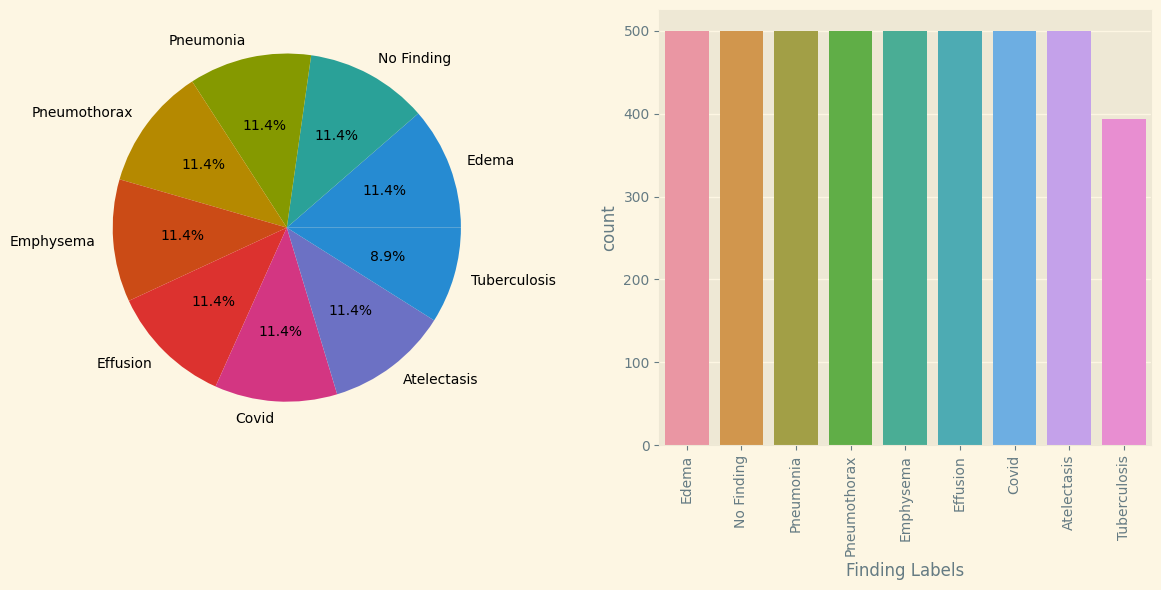

In [16]:
label_counts = df['Finding Labels'].value_counts()

plt.style.use('Solarize_Light2')

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.pie(df['Finding Labels'].value_counts(), labels=label_counts.index, autopct='%.1f%%')
# plt.legend()
plt.subplot(1,2,2)
sns.countplot(x=df['Finding Labels'], order= label_counts.index)
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


**PA vs AP**

<Figure size 1200x600 with 0 Axes>

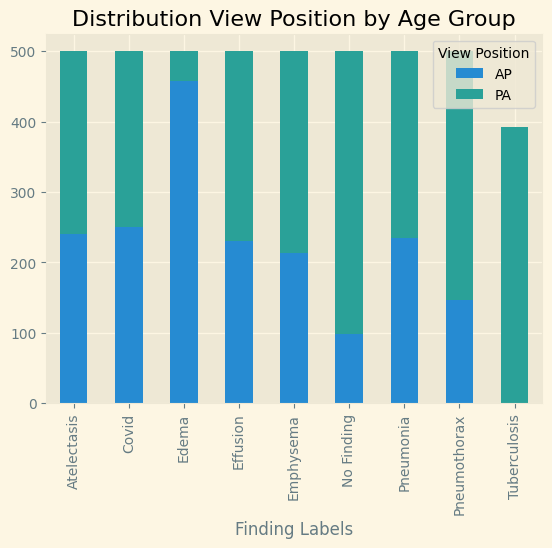

In [17]:
tmp = df.groupby(['Finding Labels','View Position']).size().unstack()
plt.figure(figsize=(12,6))
tmp.plot(kind='bar', stacked=True)
plt.title('Distribution View Position by Age Group')
plt.show()

**Train & Test Split**

In [18]:
df_train, df_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

**One Hot Encoding**

In [19]:
for col in df['Finding Labels'].unique():
    df_test[col] = np.where(df_test['Finding Labels'].str.contains(col), 1.0,0.0).astype('float32')
    df_train[col] = np.where(df_train['Finding Labels'].str.contains(col), 1.0,0.0).astype('float32')
TARGET = df_train.columns[-9:].tolist()

In [20]:
TARGET

['Edema',
 'No Finding',
 'Pneumonia',
 'Tuberculosis',
 'Pneumothorax',
 'Emphysema',
 'Covid',
 'Effusion',
 'Atelectasis']

# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>3. Build DataGenerator</b></div>

In [21]:
import albumentations as albu
print(albu.__version__)

1.4.14


In [22]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, batch_size=16, shuffle=False, augment1=False, augment2=False, augment3=False, preprocess=None):
        super().__init__()
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment1 = augment1
        self.augment2 = augment2
        self.augment3 = augment3
        self.on_epoch_end()
        self.preprocess = preprocess
        self.clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        
    def __len__(self):
        
        # Drop_Last = False
        ct = int(np.ceil(len(self.data)/self.batch_size))
        return ct
    
    def __getitem__(self,index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__data_generation(indexes)
        if self.preprocess != None: X = self.preprocess(X)
        if self.augment1: X = self.__augment1(X)
        if self.augment2: X = self.__augment2(X)
        if self.augment3: X = self.__augment3(X)
        return X,y
    
    def on_epoch_end(self,):
        self.indexes = np.arange(len(self.data))
        if self.shuffle: np.random.shuffle(self.indexes)
        
    def __data_generation(self, indexes):
        
        X = np.zeros((len(indexes),256,256,3), dtype='float32') 
        y = np.zeros((len(indexes),len(TARGET)), dtype='float32')
        
        for j,i in enumerate(indexes):
            row = self.data.iloc[i]
            path = row['path']
            
            img = Image.open(path).convert('L')  # Load image and convert to grayscale
            img = img.resize((256, 256), Image.Resampling.LANCZOS)  # Resize image
            img = np.array(img)  # Convert PIL image to numpy array
            img = self.clahe.apply(img)  # Apply CLAHE for contrast enhancement
            img = np.expand_dims(img, axis=-1)  # Expand dimensions to make it (H, W, 1)
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)  # Convert grayscale to RGB

            
            # FillNaN
            m = np.nanmean(img)
            img = np.nan_to_num(img, nan=m)    
            
            # RGB SuperPosition
            X[j,] = img
            
            y[j,] = row[TARGET]
            
        return X,y
    
    def __augment1(self, img_batch):
        
        composition = albu.Compose([
            albu.OneOf([
        albu.HorizontalFlip(p=1.0),        
        ], p=0.5),
        ])
        
        for i in range(img_batch.shape[0]):
            img = composition(image=img_batch[i,])['image']
            img_batch[i,] = img
            
        return img_batch
    
    
    def __augment2(self, img_batch, n_lines=1, p=0.5, line_folder='/kaggle/input/xray-line-augmentation'):
        for i in range(img_batch.shape[0]):
            image = img_batch[i,]
            aug_prob = random.random()
            if aug_prob <= p:
                height, width, _ = image.shape  # target image width and height
                line_images = [im for im in os.listdir(line_folder)]

                for _ in range(n_lines):
                    line = cv2.imread(os.path.join(line_folder, random.choice(line_images)))
                    line = cv2.cvtColor(line, cv2.COLOR_BGR2RGB)
                    line = cv2.flip(line, random.choice([-1, 0, 1]))  # Random flip
                    line = cv2.rotate(line, random.choice([0, 1, 2]))  # Random rotation

                    line_resized = cv2.resize(line, (width, height), interpolation=cv2.INTER_AREA)

                    # Convert line image to grayscale and create a binary mask
                    img2gray = cv2.cvtColor(line_resized, cv2.COLOR_RGB2GRAY)
                    ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
                    mask_inv = cv2.bitwise_not(mask)

                    # Prepare the background and foreground for blending
                    img_bg = cv2.bitwise_and(image, image, mask=mask_inv)
                    img_bg = img_bg.astype(np.uint8)
                    line_fg = cv2.bitwise_and(line_resized, line_resized, mask=mask)

                    # Blend the line with the original image
                    dst = cv2.add(img_bg, line_fg)

                    # Place the blended image back into the original image
                    image = dst
            img_batch[i,] = image.astype(np.float32)

        return img_batch
    
    def __augment3(self, img_batch, n_needles=1, dark_needles=False, p=0.5, needle_folder='../input/xray-needle-augmentation'):
        for i in range(img_batch.shape[0]):
            image = img_batch[i,]
            aug_prob = random.random()
            if aug_prob <= p:
                height, width, _ = image.shape  # target image width and height
                needle_images = [im for im in os.listdir(needle_folder)]

                for _ in range(n_needles):  # Ensure correct number of needles
                    needle = cv2.cvtColor(cv2.imread(os.path.join(needle_folder, random.choice(needle_images))), cv2.COLOR_BGR2RGB)
                    needle = cv2.flip(needle, random.choice([-1, 0, 1]))
                    needle = cv2.rotate(needle, random.choice([0, 1, 2]))

                    # Resize needle to match ROI dimensions
                    needle_resized = cv2.resize(needle, (width, height), interpolation=cv2.INTER_AREA)

                    # Creating a mask and inverse mask
                    img2gray = cv2.cvtColor(needle_resized, cv2.COLOR_RGB2GRAY)
                    ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
                    mask_inv = cv2.bitwise_not(mask)


                    img_bg = cv2.bitwise_and(image, image, mask=mask_inv)
                    img_bg = img_bg.astype(np.uint8)
                    if dark_needles:
                        needle_fg = cv2.bitwise_and(img_bg, img_bg, mask=mask)
                    else:
                        needle_fg = cv2.bitwise_and(needle_resized, needle_resized, mask=mask)

                    # Put needle in ROI and modify the target image
                    dst = cv2.add(img_bg, needle_fg)

                    image = dst
                    
            img_batch[i,] = image.astype(np.float32)

        return img_batch

# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>4. Build EfficientNet Model</b></div>

In [23]:
!pip install -q -U git+https://github.com/qubvel/efficientnet
    
import efficientnet.tfkeras as efn

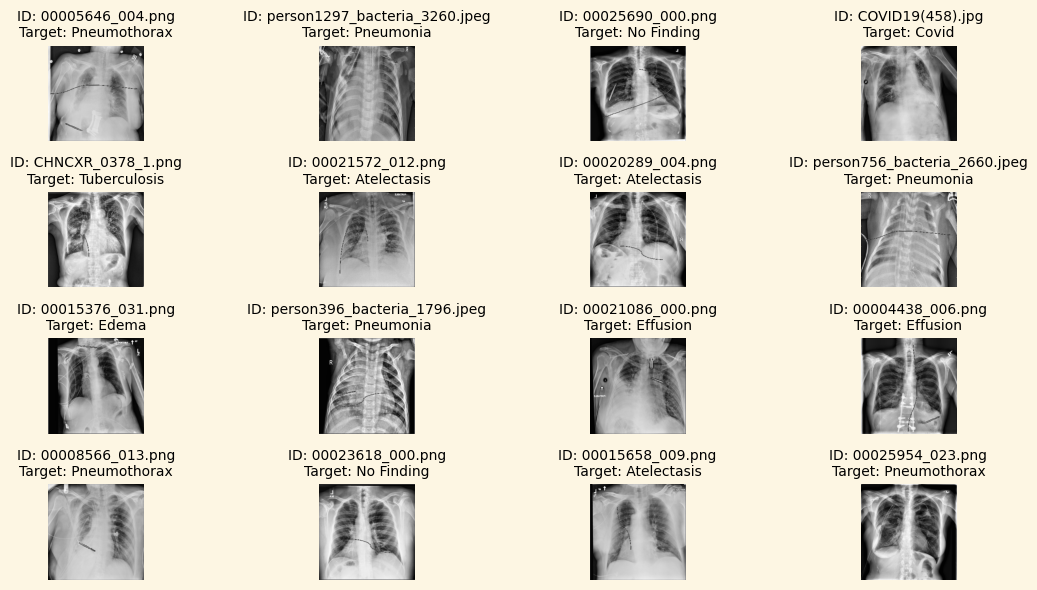

In [24]:
ROWS = 4; COLS = 4; BATCHES = 1


gen = DataGenerator(df_train, batch_size=16, shuffle=False, augment1=True, augment2=True, augment3=True, preprocess=None)

for i, (x,y) in enumerate(gen):
    plt.figure(figsize=(12,6))
    for j in range(ROWS):
        for k in range(COLS):
            plt.subplot(ROWS, COLS, j*COLS+k+1)
            img_id = df_train.iloc[i*16+j*COLS+k]['Image Index']
            plt.title(f'ID: {img_id}\nTarget: {df_train.iloc[i*16+j*COLS+k]["Finding Labels"]}', size=10)
            img = x[j*COLS+k,:,:]
            img = img.astype('uint8')
            plt.imshow(img)
            plt.axis('off')
    plt.tight_layout()
    plt.show()
    if i==BATCHES-1: break

**Macro F1 Score**

In [25]:
def f1(y_true, y_pred):
    # Calculate the F1 score for each class
    f1_scores = []
    num_classes = K.int_shape(y_pred)[-1]  # (batch_size, output_dims = num_classes)
    
    # Get the true and predicted class indices
    y_true = K.argmax(y_true, axis=-1)
    y_pred = K.argmax(y_pred, axis=-1) # For Label Smoothing(in CCE)

    for i in range(num_classes):
        
        true_positives = K.sum(K.cast(tf.logical_and(K.equal(y_true, i), K.equal(y_pred, i)), dtype=tf.float32))
        possible_positives = K.sum(K.cast(K.equal(y_true, i), dtype=tf.float32))
        predicted_positives = K.sum(K.cast(K.equal(y_pred, i), dtype=tf.float32))

        recall = true_positives / (possible_positives + K.epsilon())
        precision = true_positives / (predicted_positives + K.epsilon())
        
        f1_score = 2 * ((precision * recall) / (precision + recall + K.epsilon()))
        
        f1_scores.append(f1_score)
    
    # Calculate the macro-average F1 score
    macro_f1_score = K.mean(tf.stack(f1_scores))
    return macro_f1_score

In [26]:
def build_model():
    inp = layers.Input(shape=(256,256,3))
    base_model = efn.EfficientNetB0(include_top=False, weights=None, input_shape=(256,256,3))
    base_model.load_weights('/kaggle/input/tf-efficientnet-noisy-student-weights/efficientnet-b0_noisy-student_notop.h5')
    
    # Freezing Layers
    for layer in base_model.layers[:len(base_model.layers)//10]:
        layer.trainable = False
   
    # Output
    x = base_model(inp)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(len(TARGET), activation='softmax', dtype='float32')(x)
    
    # Compile
    model = Model(inputs=inp, outputs=x, name='efficientnet')
    loss = losses.CategoricalCrossentropy(label_smoothing=0.15)
    opt = optimizers.Adam(learning_rate=1e-3)
    
    model.compile(loss=loss, optimizer=opt, metrics=['accuracy',f1])
    
    return model

In [27]:
from tensorflow.keras.utils import plot_model
model = build_model()
model.summary()

#plot_model(model, show_shapes=True, show_layer_names=True)

Model: "efficientnet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnet-b0 (Functional)    │ (None, 8, 8, 1280)     │     4,049,564 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 9)              │        11,529 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,061,093 (15.49 MB)

 Trainable params: 4,013,529 (15.31 MB)

 Non-trainable params: 47,564 (185.80 KB)

In [28]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping 

EPOCHS = 10

es = EarlyStopping(monitor='val_f1', mode='max', patience=5)
lr = ReduceLROnPlateau(monitor = 'val_f1', factor = 0.1, patience = 1, min_delta = 0.01,
                              mode='max',verbose=1)

# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>5. Train CNN Model</b></div>

In [29]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for i, (_, valid_index) in enumerate(skf.split(df_train, df_train['Finding Labels'])):
    df_train.loc[valid_index, 'Fold'] = i

#########################
### Fold 1
### train size 2811, valid size 703
#########################
Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 304s 1s/step - accuracy: 0.3653 - f1: 0.2259 - loss: 1.8656 - val_accuracy: 0.4006 - val_f1: 0.2762 - val_loss: 1.8033 - learning_rate: 0.0010
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 140s 775ms/step - accuracy: 0.5158 - f1: 0.3181 - loss: 1.5921 - val_accuracy: 0.5114 - val_f1: 0.4064 - val_loss: 1.6523 - learning_rate: 0.0010
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 140s 772ms/step - accuracy: 0.5862 - f1: 0.3647 - loss: 1.4766 - val_accuracy: 0.5852 - val_f1: 0.4520 - val_loss: 1.6478 - learning_rate: 0.0010
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 140s 770ms/step - accuracy: 0.6190 - f1: 0.3782 - loss: 1.4390 - val_accuracy: 0.6023 - val_f1: 0.4676 - val_loss: 1.5820 - learning_rate: 0.0010
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 624ms/step - accuracy: 0.6536 - f1: 0.3999 - loss: 1.3715
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0001

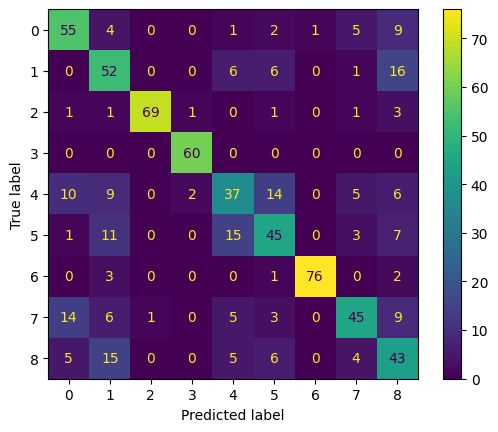

In [30]:
import tensorflow.keras.backend as K

all_oof = []
all_true = []
all_index = []
all_history = defaultdict(list)

for i in range(1):
    
    print('#'*25)
    print(f'### Fold {i+1}')
    
    train_gen = DataGenerator(df_train[df_train['Fold'] != i], shuffle=True, augment1=True, augment2=False, augment3=False, batch_size=16, preprocess=efn.preprocess_input)
    valid_gen = DataGenerator(df_train[df_train['Fold'] == i], shuffle=False, batch_size=32, preprocess=efn.preprocess_input)
    
    print(f'### train size {len(df_train[df_train["Fold"] != i])}, valid size {len(df_train[df_train["Fold"] == i])}')
    print('#'*25)
    
    K.clear_session()
    with strategy.scope():
        model = build_model()
    if LOAD_MODELS_FROM is None:
        history =  model.fit(train_gen, verbose=1,
              validation_data = valid_gen,
              epochs=EPOCHS, callbacks = [lr])
        model.save_weights(f'EffNet_f{i}.weights.h5')
        all_history['Train Loss'].append(history.history['loss'])
        all_history['Valid Loss'].append(history.history['val_loss'])
        all_history['Valid F1'].append(history.history['val_f1'])
        all_history['Train F1'].append(history.history['f1'])
        all_history['Valid Accuracy'].append(history.history['val_accuracy'])
        all_history['Train Accuracy'].append(history.history['accuracy'])

    else:
        model.load_weights(f'{LOAD_MODELS_FROM}EffNet_f{i}.weights.h5')
        
    oof = model.predict(valid_gen, verbose=1)
    all_oof.append(oof)
    all_true.append(df_train[df_train['Fold'] == i][TARGET].values)
    all_index.append(df_train[df_train['Fold'] == i]['Image Index'].values)
    
    plt.style.use('default')
    cm = confusion_matrix(np.argmax(df_train[df_train['Fold'] == i][TARGET].values, axis=1), np.argmax(oof, axis=1), labels=[x for x in range(len(TARGET))])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[x for x in range(len(TARGET))])  
    disp.plot()
    plt.show()
    
    del model, oof, train_gen, valid_gen
    gc.collect()
    
all_oof = np.concatenate(all_oof)
all_true = np.concatenate(all_true)
all_index = np.concatenate(all_index)

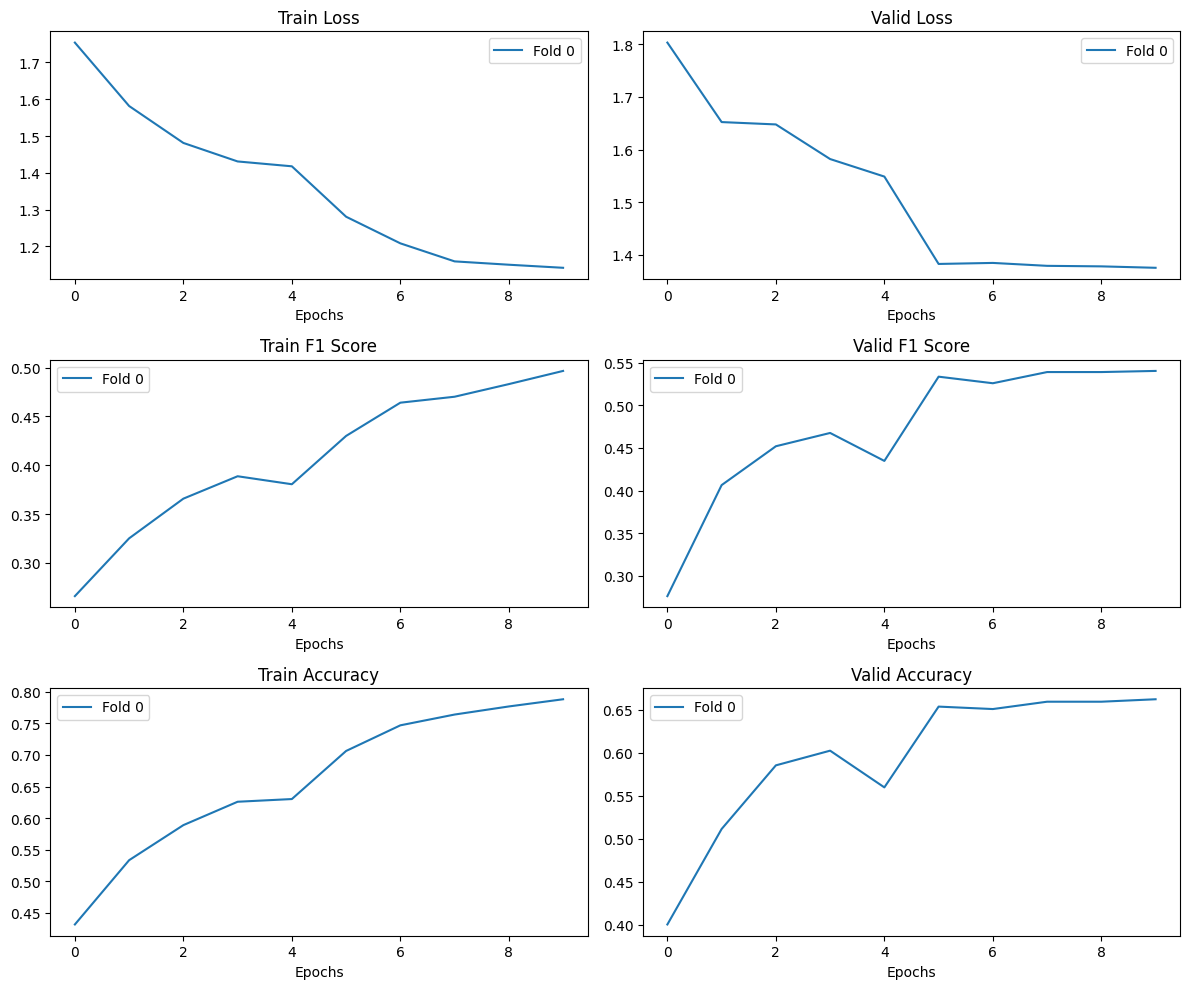

In [31]:
if LOAD_MODELS_FROM is None:
    plt.figure(figsize=(12,10))
    plt.subplot(3,2,1)
    plt.title('Train Loss')
    for fold, i in enumerate(all_history['Train Loss']):
        plt.plot(i, label=f'Fold {fold}')
        plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(3,2,2)
    plt.title('Valid Loss')
    for fold, i in enumerate(all_history['Valid Loss']):
        plt.plot(i,label=f'Fold {fold}')
        plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(3,2,3)
    plt.title('Train F1 Score')
    for fold, i in enumerate(all_history['Train F1']):
        plt.plot(i, label=f'Fold {fold}')
        plt.xlabel('Epochs')
    plt.legend()
    
    plt.subplot(3,2,4)
    plt.title('Valid F1 Score')
    for fold, i in enumerate(all_history['Valid F1']):
        plt.plot(i, label=f'Fold {fold}')
        plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(3,2,5)
    plt.title('Train Accuracy')
    for fold, i in enumerate(all_history['Train Accuracy']):
        plt.plot(i, label=f'Fold {fold}')
        plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(3,2,6)
    plt.title('Valid Accuracy')
    for fold, i in enumerate(all_history['Valid Accuracy']):
        plt.plot(i, label=f'Fold {fold}')
        plt.xlabel('Epochs')
    plt.legend()


    
    plt.tight_layout()
    plt.show()

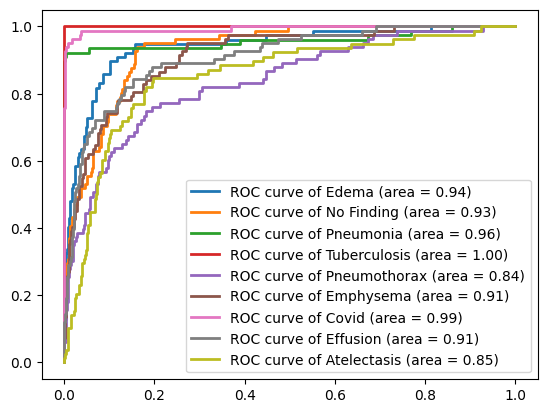

In [32]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(TARGET)):
    fpr[i], tpr[i], _ = roc_curve(all_true[:, i], all_oof[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC 곡선 그리기
plt.figure()
for i in range(len(TARGET)):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'ROC curve of {TARGET[i]} (area = {roc_auc[i]:0.2f})')
plt.legend()
plt.show()


In [33]:
# Accuracy
accuracy = accuracy_score(np.argmax(all_true, axis=1), np.argmax(all_oof, axis=1))
print('Accuracy for Train Set =', accuracy)

# F1 Score
macro_f1 = f1_score(np.argmax(all_true, axis=1), np.argmax(all_oof, axis=1) , average='macro')
print('F1 Score for Train Set =', macro_f1)

Accuracy for Train Set = 0.6856330014224751
F1 Score for Train Set = 0.697259126230702


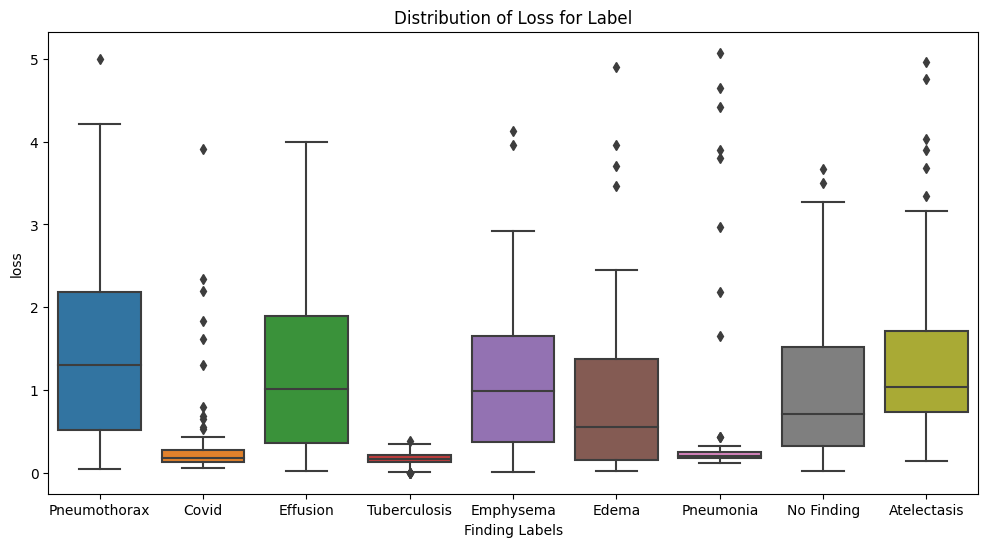

In [34]:
cce = tf.keras.losses.categorical_crossentropy(all_true, all_oof)

all_index = pd.DataFrame(all_index, columns=['Image Index'])
df_loss = pd.DataFrame(cce.numpy(), columns=['loss'])
df_loss = pd.concat([df_loss,all_index], axis=1)
df_loss = df_loss.merge(df_train, how='left', on='Image Index')

plt.figure(figsize=(12,6))

plt.title('Distribution of Loss for Label')
sns.boxplot(x='Finding Labels', y='loss', data=df_loss)
plt.show()

# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>7. Inference</b></div>

Fold 1


I0000 00:00:1725263239.633971      67 service.cc:145] XLA service 0x7f0798b29500 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725263239.634024      67 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1725263239.634029      67 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 1/14 ━━━━━━━━━━━━━━━━━━━━ 2:00 9s/step

I0000 00:00:1725263243.866677      67 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


14/14 ━━━━━━━━━━━━━━━━━━━━ 56s 4s/step
Accuracy for Test Set = 0.6746302616609784
F1 Score for Test Set = 0.6739587886305489


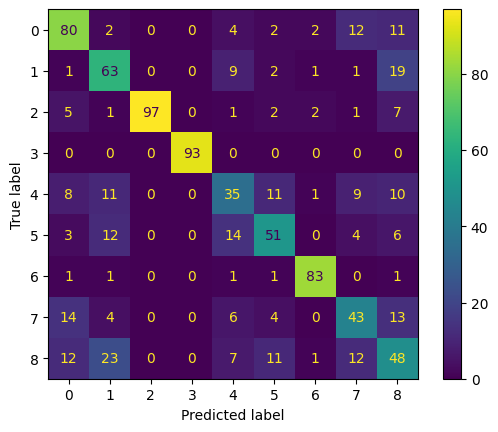

In [35]:
preds = []
model = build_model()

## No TTA
test_gen = DataGenerator(df_test, shuffle=False, batch_size=64, preprocess=efn.preprocess_input)

for i in range(1):
    print(f'Fold {i+1}') 
    if LOAD_MODELS_FROM:
        model.load_weights(f'{LOAD_MODELS_FROM}EffNet_f{i}.weights.h5')
    else: 
        model.load_weights(f'EffNet_f{i}.weights.h5')
    
    pred = model.predict(test_gen, verbose=1) 
    
preds.append(pred)
pred_res = np.mean(preds,axis=0)
    
# Accuracy 
accuracy = accuracy_score(np.argmax(df_test[TARGET].values, axis=1), np.argmax(pred_res, axis=1))
print('Accuracy for Test Set =', accuracy)

# F1 Score 
f1 = f1_score(np.argmax(df_test[TARGET].values, axis=1), np.argmax(pred_res, axis=1), average='macro') 
print('F1 Score for Test Set =', f1)

cm = confusion_matrix(np.argmax(df_test[TARGET].values, axis=1), np.argmax(pred_res, axis=1), labels=[x for x in range(len(TARGET))])
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[x for x in range(len(TARGET))])
display.plot()
plt.show()

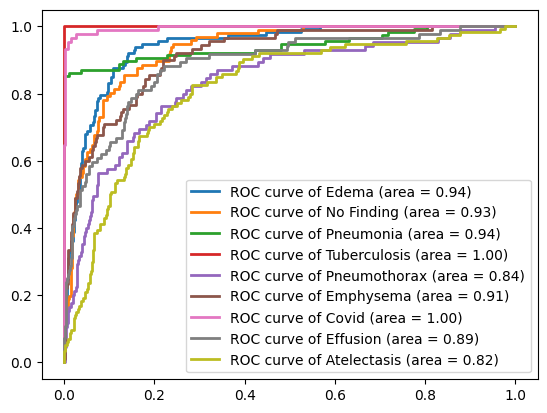

In [36]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(TARGET)):
    fpr[i], tpr[i], _ = roc_curve(df_test[TARGET[i]], pred_res[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC 곡선 그리기
plt.figure()
for i in range(len(TARGET)):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'ROC curve of {TARGET[i]} (area = {roc_auc[i]:0.2f})')
plt.legend()
plt.show()